In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import silhouette_score
from scipy.spatial import distance

## Paramaters

In [68]:
BATCH_SIZE = 128
EPOCHS = 1
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Augmentations

In [69]:
augment_sets = {
  "Flip&Crop" : [
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ],
  "Rotation" : [
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ]
}

## Utility functions

In [70]:
def get_dataloaders(augmentations):
    transform_train = transforms.Compose(augmentations)
    transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    full_train = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_val)
    train_size = int(0.8 * len(full_train))
    val_size = len(full_train) - train_size
    train_dataset, val_dataset = random_split(full_train, [train_size, val_size])
    
    # Apply augmentation only to training set
    train_dataset.dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    return train_loader, val_loader

def build_model():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model.to(DEVICE)

def train_model(model, train_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss/len(train_loader):.4f}")

def extract_features(model, dataloader):
    model.eval()
    features, labels_list = [], []
    def hook(module, input, output):
        features.append(output.detach().cpu().numpy())
    model.layer4[-1].register_forward_hook(hook)
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(DEVICE)
            _ = model(images)  # Forward pass to trigger the hook
            labels_list.extend(labels.numpy())
    
    return np.concatenate(features, axis=0), np.array(labels_list)


def kullback_leibler_divergence(p, q):
    p_norm = p / np.sum(p)
    q_norm = q / np.sum(q)
    return distance.rel_entr(p_norm + 1e-10, q_norm + 1e-10).sum()



def visualize(train_features, train_labels, val_features, val_labels, name):
    
    fig, axs = plt.subplots(ncols = 2, figsize=(16,8))

    # t-SNE vis
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(train_features.reshape(train_features.shape[0], -1))
    plt.figure(figsize=(8, 6))

    axs[0].scatter(features_2d[:, 0], features_2d[:, 1], c=train_labels, cmap="jet", alpha=0.5)
    axs[0].set_title('t-SNE of augmented dataset features')
    
    all_features = np.vstack((train_features, val_features))
    labels = np.array([0] * len(train_features) + [1] * len(val_features))  # 0 for train, 1 for val
    
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(all_features.reshape(all_features.shape[0], -1))
    
    axs[1].scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap="coolwarm", alpha=0.5)
    axs[1].set_title('Silhouette visualization')

    score = silhouette_score(all_features.reshape(all_features.shape[0], -1), labels)
    kl_div = kullback_leibler_divergence(np.mean(train_features, axis=0), np.mean(val_features, axis=0))
    fig.suptitle(f"Augmentations: {name}\nt-SNE Visualization Silhouette Score: {score:.4f} | KL Divergence: {kl_div:.4f}", fontsize=12)
    
    plt.show()

def run_pipeline(augmentations, name):
    print('Getting dataloaders...')
    train_loader, val_loader = get_dataloaders(augmentations)
    
    print('Building model...')
    model = build_model()
    
    print('Training model...')
    train_model(model, train_loader)

    print('Extracting features...')
    train_features, train_labels = extract_features(model, train_loader)
    val_features, val_labels = extract_features(model, val_loader)

    print('Creating visualization...')
    visualize(train_features, train_labels, val_features, val_labels, name)




Running pipeline for augmentation: Flip&Crop
Getting dataloaders...
Building model...
Training model...


c:\Users\skypl\Documents\GitHub\Diplomka\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\skypl\Documents\GitHub\Diplomka\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/1], Loss: 1.0747
Extracting features...
Creating visualization...


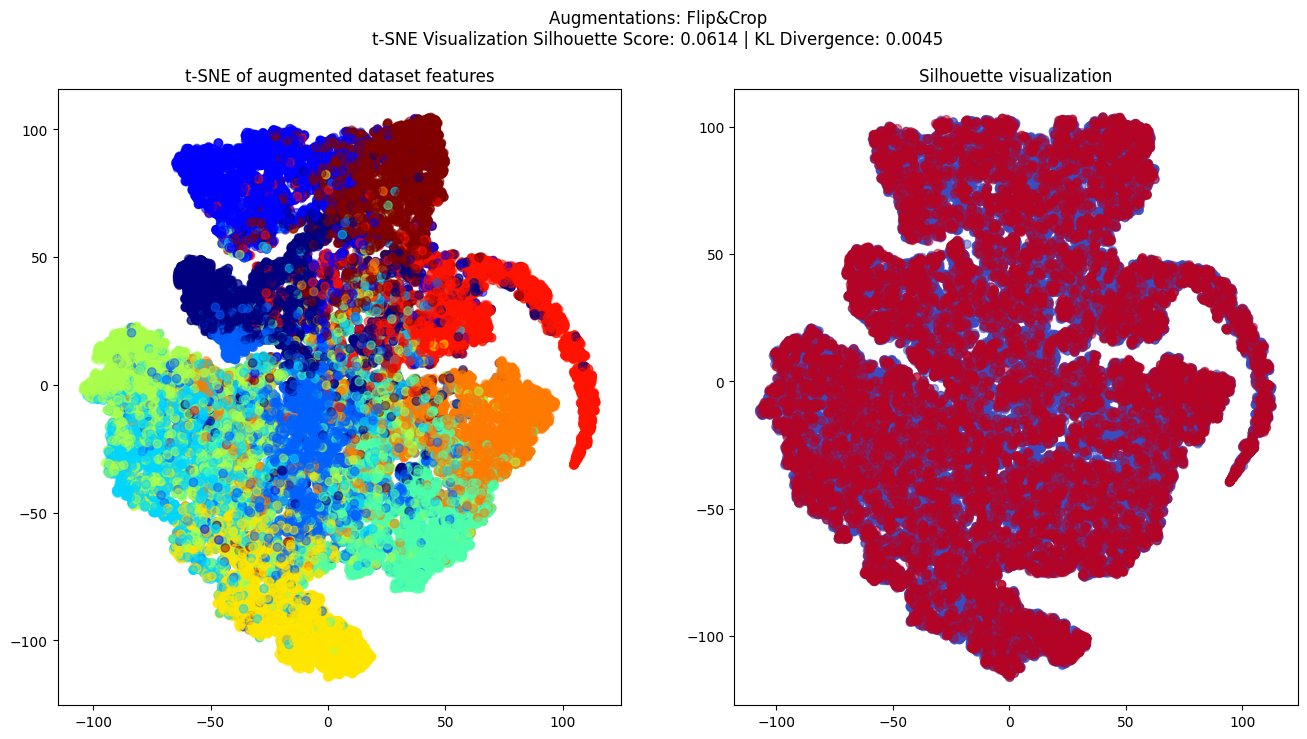

<Figure size 800x600 with 0 Axes>


Running pipeline for augmentation: Rotation
Getting dataloaders...
Building model...
Training model...


c:\Users\skypl\Documents\GitHub\Diplomka\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\skypl\Documents\GitHub\Diplomka\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/1], Loss: 1.0707
Extracting features...
Creating visualization...


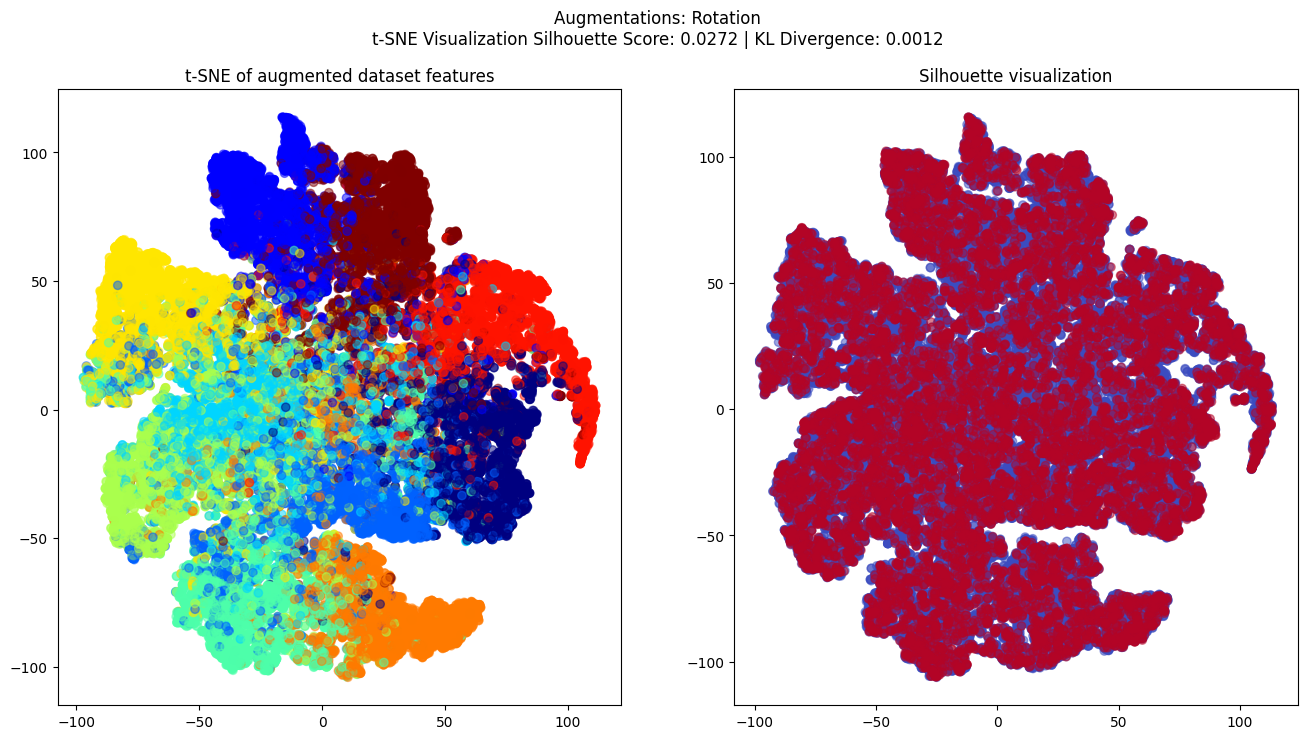

<Figure size 800x600 with 0 Axes>

In [71]:
for name, aug in augment_sets.items():
  print(f"\nRunning pipeline for augmentation: {name}")
  run_pipeline(aug, name)